In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [19]:
users_df = pd.read_csv('takehome_users-intern.csv')
campaigns_df = pd.read_csv('market_campaigns.csv', parse_dates=['start_date', 'end_date'])

In [20]:

campaigns_df['start_date'] = pd.to_datetime(campaigns_df['start_date'])
campaigns_df.set_index('start_date', inplace=True)

monthly_conversions = campaigns_df['conversions'].resample('M').sum()

monthly_conversions.head()

start_date
2014-01-31    204068
2014-02-28    164253
2014-03-31    176655
2014-04-30    183042
2014-05-31    187853
Freq: M, Name: conversions, dtype: int64

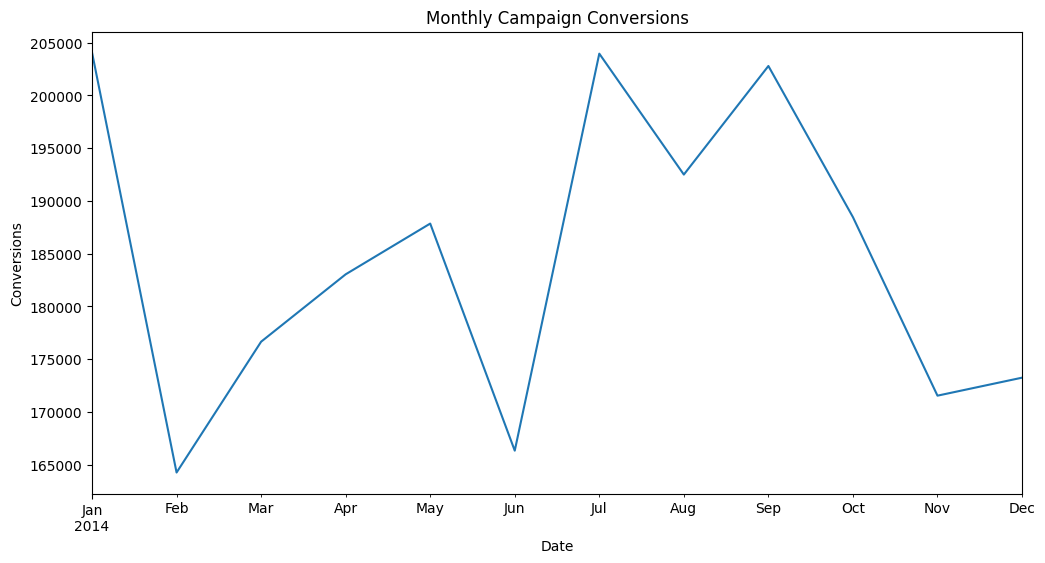

/Users/sunaysanghani/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunaysanghani/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


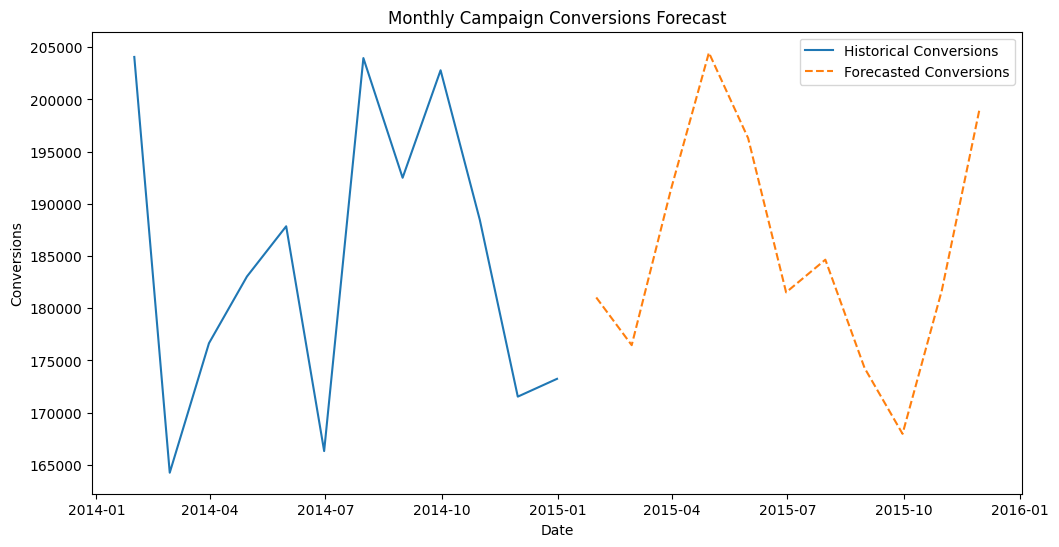

In [21]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Plot the time series
monthly_conversions.plot(figsize=(12, 6))
plt.title('Monthly Campaign Conversions')
plt.xlabel('Date')
plt.ylabel('Conversions')
plt.show()

# Fit the ARIMA model
model = ARIMA(monthly_conversions, order=(6,1,2))  # Adjust the order (p, d, q) as needed
model_fit = model.fit()

forecast = model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=monthly_conversions.index[-1], periods=12, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_conversions, label='Historical Conversions')
plt.plot(forecast_series, label='Forecasted Conversions', linestyle='--')
plt.title('Monthly Campaign Conversions Forecast')
plt.xlabel('Date')
plt.ylabel('Conversions')
plt.legend()
plt.show()

In [22]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            conversions   No. Observations:                   12
Model:                 ARIMA(6, 1, 2)   Log Likelihood             -114432.255
Date:                Sun, 14 Jul 2024   AIC                         228882.510
Time:                        20:04:33   BIC                         228886.091
Sample:                    01-31-2014   HQIC                        228880.252
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1541      0.000  -3202.286      0.000      -1.155      -1.153
ar.L2         -0.4761   9.02e-05  -5276.321      0.000      -0.476      -0.476
ar.L3         -0.6317   3.46e-05  -1.83e+04      0.000      -0.632      -0.632
ar.L4         -0.4751   2.79e-05   -1.7e+04      0.000      -0.475      -0.475
ar.L5         -1.1592   1.96e-05  -5.91e+04      0.000      -1.159      -1.159
ar.L6         -0.9939      0.000  -2258.491      0.000      -0.995      -0.993
ma.L1         -0.0016      0.001     -1.129      0.259      -0.004       0.001
ma.L2         -0.9984      0.001  -1815.204      0.000      -1.000      -0.997
sigma2      6072.2666   1.14e-07   5.31e+10      0.000    6072.267    6072.267
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 1.65
Prob(Q):                              0.30   Prob(JB):                         0.44
Heteroskedasticity (H):              96.35   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+24. Standard errors may be unstable.
"""

In [23]:
engagement_df = pd.read_csv('takehome_user_engagement-intern.csv')


In [24]:
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

In [25]:
user_engagement = engagement_df.groupby('user_id')['visited'].sum().reset_index()
user_engagement.tail(20)

,user_id,visited
8803,11977,1
8804,11979,1
8805,11980,8
8806,11981,4
8807,11982,1
8808,11983,1
8809,11984,1
8810,11986,1
8811,11987,1
8812,11988,30


In [26]:
user_engagement['visited'].describe()

count    8823.000000
mean       23.565341
std        73.988152
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       606.000000
Name: visited, dtype: float64

In [27]:
comparison_threshold = user_engagement['visited'].quantile(0.75)
low_threshold = user_engagement['visited'].quantile(0.25)
user_engagement['highly_engaged'] = (user_engagement['visited'] > comparison_threshold).astype(int)
user_engagement['lowly_engaged'] = (user_engagement['visited'] <= low_threshold).astype(int)
user_engagement['mid_engaged'] = ((user_engagement['visited'] <= comparison_threshold) & (user_engagement['visited'] > user_engagement['visited'].quantile(0.50))).astype(int) # for those that are mid engaged, how do we turn them into customers that are in high

In [28]:
user_engagement.head()

,user_id,visited,highly_engaged,lowly_engaged,mid_engaged
0,1,1,0,1,0
1,2,14,1,0,0
2,3,1,0,1,0
3,4,1,0,1,0
4,5,1,0,1,0


In [29]:
from sklearn.model_selection import train_test_split
users_segmented = pd.merge(user_engagement, users_df, left_on='user_id', right_on='object_id')

users_segmented = pd.get_dummies(users_segmented, columns=['creation_source'])
X = users_segmented[['enabled_for_marketing_drip', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH', 'opted_in_to_mailing_list', 'last_session_creation_time']]
y = users_segmented['highly_engaged']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_test.head()

,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list,last_session_creation_time
5643,1,False,False,False,False,True,1,1.346502e+09
6808,0,True,False,False,False,False,1,1.375962e+09
4593,0,False,False,False,True,False,0,1.401461e+09
5505,0,False,False,False,False,True,0,1.376961e+09
766,0,False,False,False,True,False,0,1.401699e+09


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Initialize the models
log_reg = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier()
svc = SVC()
grad_boost = GradientBoostingClassifier()

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

models = {
    'Logistic Regression': log_reg,
    'Random Forest': random_forest,
    'Support Vector Machine': svc,
    'Gradient Boosting': grad_boost
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Model')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('-' * 50)

Logistic Regression Model
Accuracy: 0.7626062322946175
[[1346    0]
 [ 419    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.87      1346
           1       0.00      0.00      0.00       419

    accuracy                           0.76      1765
   macro avg       0.38      0.50      0.43      1765
weighted avg       0.58      0.76      0.66      1765

--------------------------------------------------


/Users/sunaysanghani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sunaysanghani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sunaysanghani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Random Forest Model
Accuracy: 0.7869688385269121
[[1156  190]
 [ 186  233]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1346
           1       0.55      0.56      0.55       419

    accuracy                           0.79      1765
   macro avg       0.71      0.71      0.71      1765
weighted avg       0.79      0.79      0.79      1765

--------------------------------------------------
Support Vector Machine Model
Accuracy: 0.7626062322946175
[[1346    0]
 [ 419    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.87      1346
           1       0.00      0.00      0.00       419

    accuracy                           0.76      1765
   macro avg       0.38      0.50      0.43      1765
weighted avg       0.58      0.76      0.66      1765

--------------------------------------------------


/Users/sunaysanghani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sunaysanghani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sunaysanghani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Gradient Boosting Model
Accuracy: 0.8668555240793201
[[1278   68]
 [ 167  252]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1346
           1       0.79      0.60      0.68       419

    accuracy                           0.87      1765
   macro avg       0.84      0.78      0.80      1765
weighted avg       0.86      0.87      0.86      1765

--------------------------------------------------


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Accuracy: 0.7626062322946175
Confusion Matrix:
[[1346    0]
 [ 419    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.87      1346
           1       0.00      0.00      0.00       419

    accuracy                           0.76      1765
   macro avg       0.38      0.50      0.43      1765
weighted avg       0.58      0.76      0.66      1765



/Users/sunaysanghani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sunaysanghani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sunaysanghani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=5)

# Perform KFold cross-validation
cv_scores_kfold = cross_val_score(model, X, y, cv=kf)

# Print the KFold cross-validation scores
print("KFold cross-validation scores:", cv_scores_kfold)
print("Mean KFold cross-validation score:", np.mean(cv_scores_kfold))
print("Standard deviation of KFold cross-validation scores:", np.std(cv_scores_kfold))

KFold cross-validation scores: [0.77167139 0.76713881 0.78640227 0.77494331 0.76247166]
Mean KFold cross-validation score: 0.7725254861151261
Standard deviation of KFold cross-validation scores: 0.008114630956980532


In [35]:
engagement_df.head(2)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [36]:
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

# Aggregate engagement data to get the total number of visits per user
total_visits = engagement_df.groupby('user_id').sum(numeric_only=True).reset_index()

# Merge the user data with the aggregated engagement data
merged_df = pd.merge(users_df, total_visits, left_on='object_id', right_on='user_id')
merged_df = merged_df.drop(columns=['user_id'])
from sklearn.model_selection import train_test_split
users_segmented = pd.merge(user_engagement, users_df, left_on='user_id', right_on='object_id')

X = users_segmented[['visited', 'opted_in_to_mailing_list']]
y = users_segmented['highly_engaged']

/var/folders/jz/tjq4kww13xgcbgf1jbg9w7_00000gn/T/ipykernel_20594/832654878.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])


In [37]:
import numpy as np

# Calculate the number of days since the user was created
merged_df['days_since_creation'] = (pd.Timestamp.now() - merged_df['creation_time']).dt.days

# Calculate the number of days since the last session
merged_df['days_since_last_session'] = (pd.Timestamp.now() - pd.to_datetime(merged_df['last_session_creation_time'], unit='s')).dt.days

# Calculate visit frequency (visits per day since creation)
merged_df['visit_frequency'] = merged_df['visited'] / merged_df['days_since_creation']

# Calculate engagement levels
comparison_threshold = merged_df['visited'].quantile(0.75)
low_threshold = merged_df['visited'].quantile(0.25)
merged_df['highly_engaged'] = (merged_df['visited'] > comparison_threshold).astype(int)
merged_df['lowly_engaged'] = (merged_df['visited'] <= low_threshold).astype(int)
merged_df['mid_engaged'] = ((merged_df['visited'] <= comparison_threshold) & (merged_df['visited'] > merged_df['visited'].quantile(0.50))).astype(int)

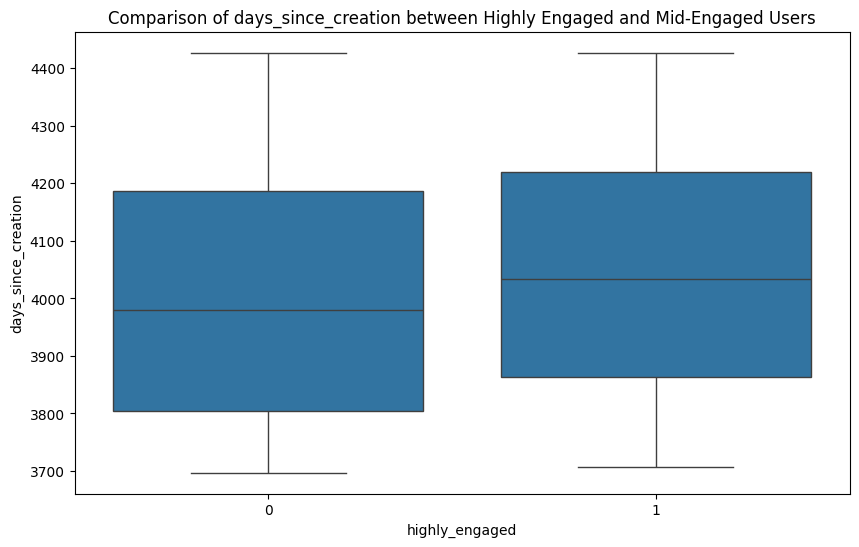

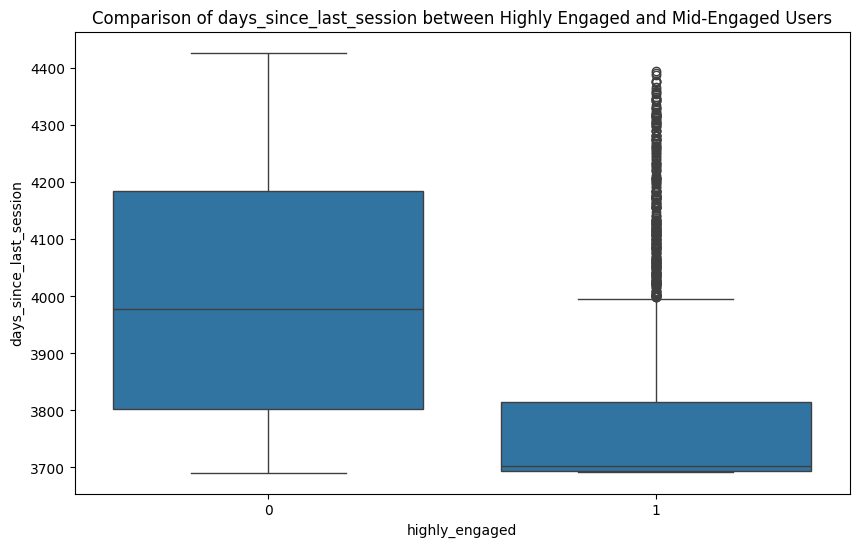

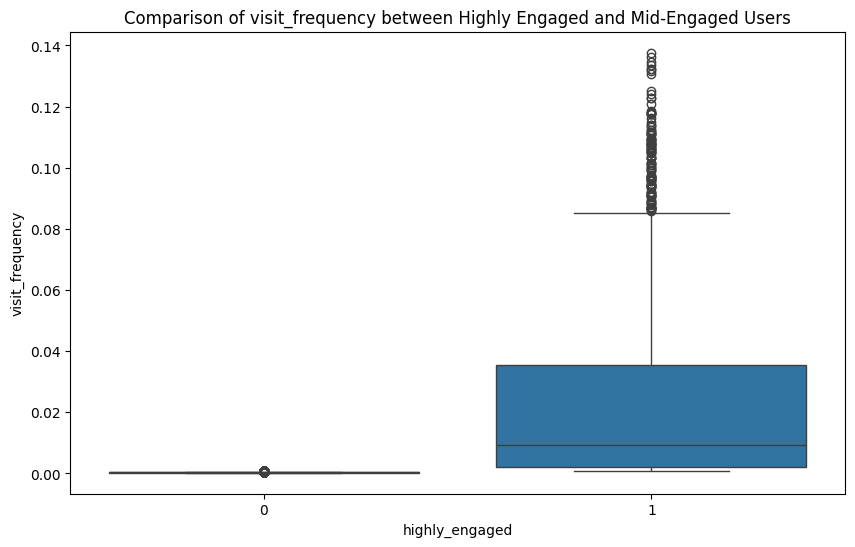

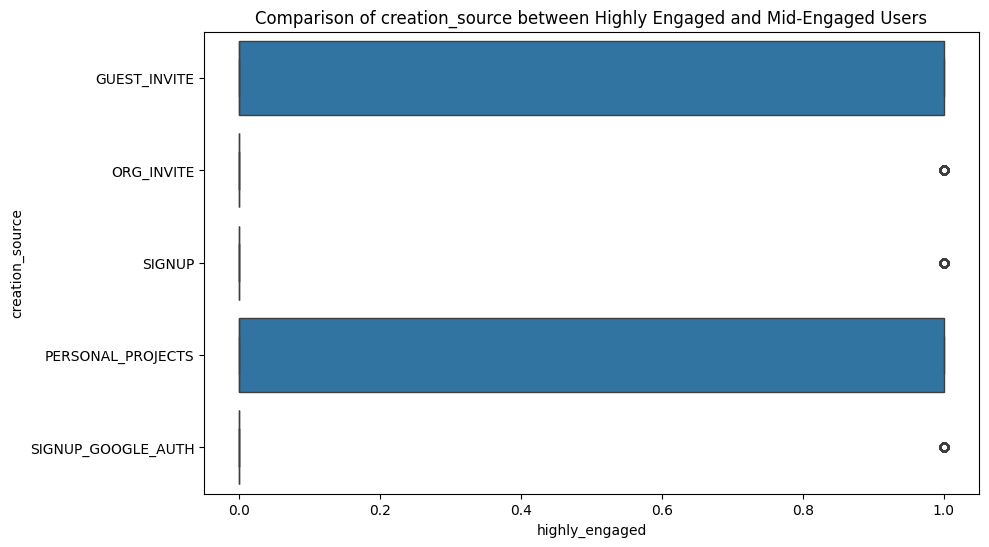

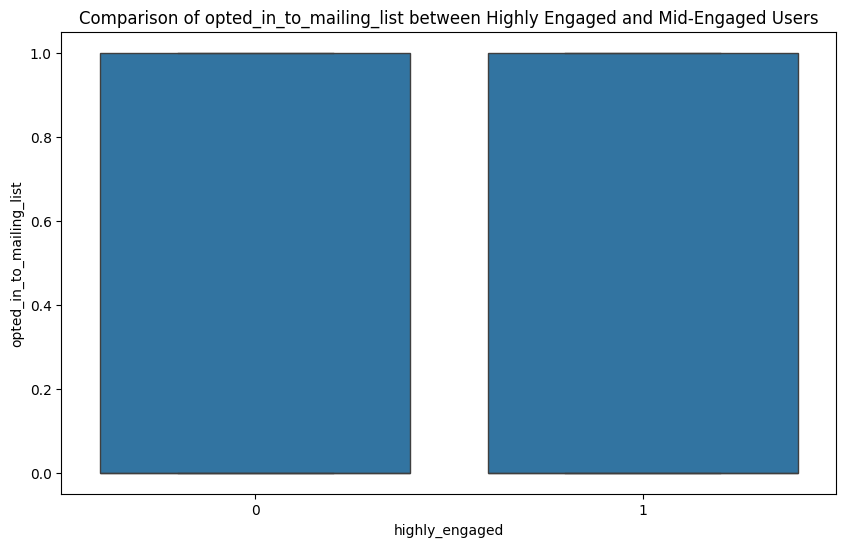

In [38]:
import seaborn as sns

features_to_compare = ['days_since_creation', 'days_since_last_session', 'visit_frequency', 'creation_source', 'opted_in_to_mailing_list']

for feature in features_to_compare:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='highly_engaged', y=feature, data=merged_df)
    plt.title(f'Comparison of {feature} between Highly Engaged and Mid-Engaged Users')
    plt.show()

In [39]:
creation_source_counts = merged_df['creation_source'].value_counts()
print("Creation Source Counts:")
print(creation_source_counts)

Creation Source Counts:
creation_source
ORG_INVITE            3188
SIGNUP                1898
GUEST_INVITE          1588
SIGNUP_GOOGLE_AUTH    1385
PERSONAL_PROJECTS      764
Name: count, dtype: int64


In [77]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
merged_df['creation_source_encoded'] = label_encoder.fit_transform(merged_df['creation_source'])
merged_df.fillna(0)
# Select relevant features including the encoded 'creation_source'
features = ['days_since_creation', 'enabled_for_marketing_drip','invited_by_user_id', 'days_since_last_session', 'opted_in_to_mailing_list', 'creation_source_encoded']
X = merged_df[features]
y = merged_df['highly_engaged']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [80]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.9473087818696884
Confusion Matrix:
[[1331   15]
 [  78  341]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1346
           1       0.96      0.81      0.88       419

    accuracy                           0.95      1765
   macro avg       0.95      0.90      0.92      1765
weighted avg       0.95      0.95      0.95      1765



In [82]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Score: {np.mean(cv_scores)}')
print(f'Standard Deviation of Cross-Validation Scores: {np.std(cv_scores)}')

Cross-Validation Scores: [0.9490085  0.94475921 0.94830028 0.95535082 0.96172927]
Mean Cross-Validation Score: 0.9518296147429244
Standard Deviation of Cross-Validation Scores: 0.006013444461654034


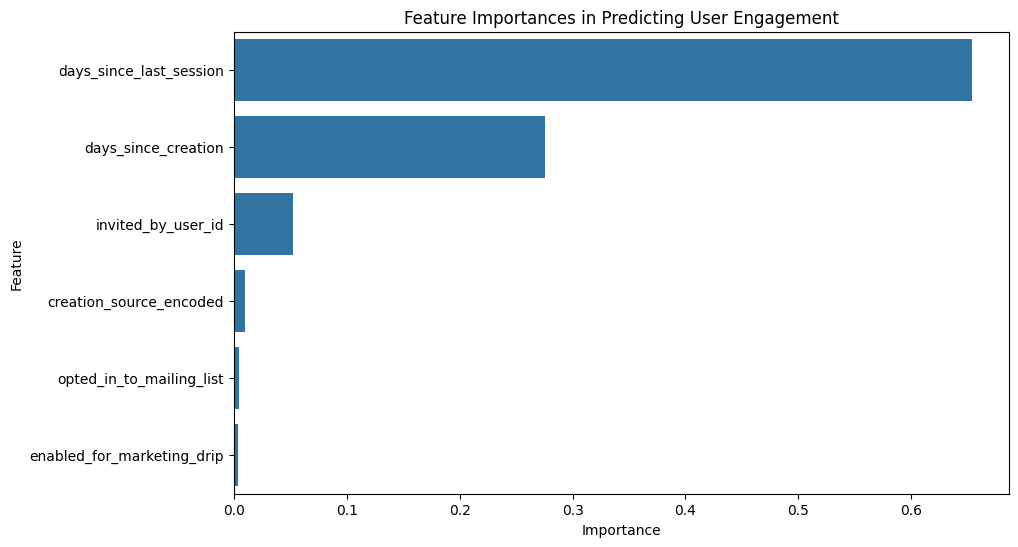

In [81]:
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances in Predicting User Engagement')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Writeup:

Predicting the highly engaged user via creation source is extremely doable with the data given. The data suggests that there is a clear advantage with some user sign up types such as guest invite or personal projects seem to have a high chance of creating highly engaged users (users that visit Asana in this data set for more than 75% of other users). I would recommend that Asana perform marketing campaigns targeted towards encouraging people to use the platform for personal projects. Additionally, it is important to see new types of data which could make the model stronger in the future and make the predictive capabilites better. However, the feature importance graph is showing that that the days_since_last_session, days_since_creation, and invited_by_user_id are some of the most important features. One of out those 3 are creation sources(invited by user ID). Days since last session is an obvious indicator of a highly engaged users. Can Asana gamify their app kind of like Duolingo? It can allow users to come back to their app and create a repetition pattern. Marketing campaigns and monetary implications for that would be most worthwile according to this model. Additionally, days_since_creation is another indicator. It seems like it is better to get users to strike and use the platform as much as possible in the early days of the software. If users are targeted and given incentives to use the platform soon after they create an account, they are more likely to be a highly engaged user. Lastly, the creation source with the most importance is the user id. Providing users with promo codes or incentives to invite other users could provide to be lucrative. The user target base can be broader and lead to larger results as all current users of Asana can be targeted for this strategy. In comparison, the other two important features only applies to a sector of Asana users as only some of them have a low days_since_creation and a low days_since_last_session. I recommend Asana really invest resources into building out a invited_by_user_id plan to get more signups to their platform.
